In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import GPy
import GPyOpt
import copy
import time
import datetime

class Model:
    # Network Parameters
    # n_neurons, learning_rate, num_layers, rnn_type(RNN|BasicLSTM|LSTM|LSTM peelhole)
    # Control Parameters
    # risk_aversion - the margin added to the courtage that leads an buy or sell operation
    # learning_period - how many sequences model should learn before predicting next sequences
    # prediction_period - how many sequences the model should predict
    # max_repeats - how many times in maximum the model should learn
    # min_profit - what is the minimum profit in average during training phase, if the minimum is not reached, the model should not predict
    # gamma - what is the gamma used when preprocessing data
    
    step_profit_list = []
    mixed_domain = [{'name': 'n_neurons', 'type': 'discrete', 'domain': tuple(range(20,160,20))},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (0.001,0.002,0.003,0.004)},
          {'name': 'num_layers', 'type': 'discrete', 'domain': (1,2,3,4)},
          {'name': 'rnn_type', 'type': 'discrete', 'domain': (0,1,2)},
          {'name': 'learning_period', 'type': 'discrete', 'domain': tuple(range(10,40,10))},
          {'name': 'prediction_period', 'type': 'discrete', 'domain': tuple(range(5,10,5))},
          {'name': 'max_repeats', 'type': 'discrete', 'domain': tuple(range(1,50,10))},
          {'name': 'beta', 'type': 'discrete', 'domain': (99, 98)},
          {'name': 'ema', 'type': 'discrete', 'domain': (10,20)},
          {'name': 'time_input', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'volume_input', 'type': 'discrete', 'domain': (0,1)},
         ]
    def __init__(self, regen):
        if regen == False:
            return
        def column_filter(x):
            if x == 'stepofweek':
                return True
            elif 'diff_ema' in x:
                return True
            elif 'volume' in x:
                return True
            elif 'value_ema' in x:
                return True
            else:
                return False
        for ema in (10, 20):
            for beta in (99, 98):
                filename = "data-prep-ema{}-beta{}.csv".format(ema, beta)
                print("pre-processing {}".format(filename))
                data = pd.read_csv(filename, parse_dates=["timestamp"])
                data['dayofweek'] = data['timestamp'].apply(lambda x: x.weekday())
                groups = data.set_index('timestamp').groupby(lambda x: x.date())
                
                # get maximum steps
                max_steps = 0
                for index, df in groups:
                    df_len = len(df)
                    if df_len > max_steps:
                        max_steps = df_len
                        
                np_data = np.zeros((len(groups), max_steps, 30*3+1))
                filtered_columns = list(filter(column_filter, data.columns))

                i = 0
                for index, df in groups:
                    df['stepofday'] = np.arange(0, max_steps)
                    df['stepofweek'] = df['dayofweek'] * max_steps + df['stepofday']
                    np_data[i] = df[['stepofweek'] + filtered_columns ].to_numpy()

                    i += 1
                    
                numpy_file_name = "np_ema{}_beta{}.npz".format(ema, beta)
                np.savez_compressed(numpy_file_name, np_data)
                

        return
        
    def get_parameter_str(self, X):
        parameter_str = ""
        for i in range(len(self.mixed_domain)):
            parameter_str += self.mixed_domain[i]["name"]
            parameter_str += ':'
            parameter_str += str(X[i])
            parameter_str += ','
        return parameter_str
    
    def reset_graph(self, seed=42):
        tf.reset_default_graph()
        tf.set_random_seed(seed)
        np.random.seed(seed)
        
    
    def log(self, verbose, msg):
        if verbose:
            print(msg)

    def get_batch(self, seq_index, data_train_input, data_train_output):
        X_batch = data_train_input[seq_index:seq_index+1]
        y_batch = data_train_output[seq_index:seq_index+1]
        return X_batch, y_batch
    
    def transform(self, data_all, n_inputs, n_outputs):
        orig_shape = data_all.shape
        data_train_reshape = data_all.reshape((orig_shape[0] * orig_shape[1], orig_shape[2]))
        
        self.scaler_input = preprocessing.MinMaxScaler().fit(data_train_reshape[:,:n_inputs])
        data_train_input_scaled = self.scaler_input.transform(data_train_reshape[:,:n_inputs])
        
        # the invalid step, we change it to zero!
        data_train_input_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_input = data_train_input_scaled.reshape(orig_shape[0], orig_shape[1], n_inputs)
        
        self.scaler_output = preprocessing.MinMaxScaler().fit(data_train_reshape[:,-n_outputs:])
        data_train_output_scaled = self.scaler_output.transform(data_train_reshape[:,-n_outputs:])
        # the invalid step, we change it to zero!
        data_train_output_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_output = data_train_output_scaled.reshape(orig_shape[0], orig_shape[1], n_outputs)
        
        return data_train_input, data_train_output
    
    def inverse_transform_output(self, scaled_outputs):
        outputs_reshaped = scaled_outputs.reshape((scaled_outputs.shape[1], scaled_outputs.shape[2]))
        #outputs = np.exp(self.scaler_output.inverse_transform(outputs_reshaped)) - 1
        outputs = self.scaler_output.inverse_transform(outputs_reshaped)
        return outputs
    
    def inverse_transform_input(self, scaled_inputs):
        inputs_reshaped = scaled_inputs.reshape((scaled_inputs.shape[1], scaled_inputs.shape[2]))
        #inputs_reshaped[:,4:6] = np.exp(self.scaler_input.inverse_transform(inputs_reshaped)[:,4:6]) - 1
        inputs = self.scaler_input.inverse_transform(inputs_reshaped)
        # TODO: the volume and hold should be transformed back.
        return inputs
        
        
    def get_answer(self, features):
        n_neurons = int(features[0])
        learning_rate = features[1]
        num_layers = int(features[2])
        rnn_type = int(features[3])
        learning_period = int(features[4])
        prediction_period = int(features[5])
        max_repeats = int(features[6])
        beta = int(features[7])
        ema = int(features[8])
        time_input = int(features[9])
        volume_input = int(features[10])

        # load data
        file_name = "np_ema{}_beta{}.npz".format(ema, beta)
        data_all = np.load(file_name)['arr_0']
        # pick the data for stock_id
        stock_index = 20
        # we must convert the array to 2D
        orig_shape = data_all.shape
        print("original shape: ")
        print(orig_shape)
        reshaped_data = data_all.reshape((orig_shape[0] * orig_shape[1], orig_shape[2]))
        
        # the mandatory is the diff.
        input_column_list = [1 + 30 + stock_index]
        if time_input != 0:
            input_column_list = [0] + input_column_list
        if volume_input != 0:
            input_column_list = input_column_list + [1 + stock_index]
            
        output_column_list = [1 + 60 + stock_index]
        
        reshaped_data_filtered = reshaped_data[:, input_column_list + output_column_list]
        # for volume we use log.
        if volume_input != 0:
            # the last column is the volume
            last_input_index = len(input_column_list)-1
            # we must add 1 to the volume value otherwise log(0) is meaningless.
            reshaped_data_filtered[:, last_input_index] = np.log(reshaped_data_filtered[:, last_input_index]+1)
        
        n_inputs = len(input_column_list)
        n_outputs = len(output_column_list)
        data_filtered = reshaped_data[:, input_column_list + output_column_list].reshape((orig_shape[0], orig_shape[1], n_inputs+n_outputs))
        

        batch_size = 1
        data_train_input, data_train_output = self.transform(data_filtered, n_inputs, n_outputs)

        # data_train_input in the shape [seq, steps, features]
        days = data_train_input.shape[0]
        max_steps = data_train_input.shape[1]

        self.reset_graph()
        
        X = tf.placeholder(tf.float32, [None, max_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, max_steps, n_outputs])
        
        layers = None
        if rnn_type == 0:
            layers = [tf.nn.rnn_cell.BasicLSTMCell(n_neurons) 
              for _ in range(num_layers)]
        elif rnn_type == 1:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=False) 
              for _ in range(num_layers)]
        elif rnn_type == 2:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=True) 
              for _ in range(num_layers)]
        else:
            print("WRONG")
        cell = tf.nn.rnn_cell.MultiRNNCell(layers)
        
        # For each layer, get the initial state. states will be a tuple of LSTMStateTuples.
        init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, n_neurons])
        state_per_layer_list = tf.unstack(init_state, axis=0)
        rnn_tuple_state = tuple(
            [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )

        rnn_outputs, new_states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, 
                                                    initial_state=rnn_tuple_state)
        
        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, max_steps, n_outputs])
        
        
        loss = tf.reduce_mean(tf.square(outputs - y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        # now run the model to get answer:
        rnn_states_before_training = np.zeros((num_layers, 2, batch_size, n_neurons))
        graph_data = []
        my_loss_test_list = []
        my_test_results_list = []
        my_test_answers_list = []
        with tf.Session() as sess:
            init.run()
            for learn_end_seq in range(learning_period, 
                                       days - prediction_period, 
                                       prediction_period):
                learning_start_seq = learn_end_seq - learning_period
                tmp_states = np.zeros((num_layers, 2, batch_size, n_neurons))
                for repeat in range(max_repeats):
                    rnn_states = copy.deepcopy(rnn_states_before_training)
                    my_loss_train_list = []
                    train_asset = 1
                    for seq in range(learning_start_seq, learn_end_seq):
                        X_batch, y_batch = self.get_batch(seq, data_train_input, data_train_output)
                        feed_dict = {
                            X: X_batch,
                            y: y_batch,
                            init_state: rnn_states_before_training
                        }
                        
                        my_op, my_new_states, my_loss_train, my_outputs = sess.run([training_op, new_states, loss, outputs], feed_dict=feed_dict)
                        my_loss_train_list.append(my_loss_train)
                        rnn_states = my_new_states
                        if seq - learning_start_seq == prediction_period:
                            # next training loop starts from here
                            tmp_states = copy.deepcopy(rnn_states)
                    my_loss_train_avg = sum(my_loss_train_list) / len(my_loss_train_list)
                    print("{} sequence:{} - {} repeat={} training finished, training MSE={}".format(
                        datetime.datetime.now().time(),
                        learning_start_seq, learn_end_seq, 
                        repeat, my_loss_train_avg))
                # backup the states after training.
                rnn_states_before_training = copy.deepcopy(tmp_states)
                
                
                for seq in range(learn_end_seq, learn_end_seq + prediction_period):
                    X_test, y_test = self.get_batch(seq, data_train_input, data_train_output)
                    feed_dict = {
                        X: X_test,
                        y: y_test,
                        init_state: rnn_states,
                    }
            
                    my_new_states, my_loss_test, my_outputs = sess.run([new_states, loss, outputs], feed_dict=feed_dict)
                    my_loss_test_list.append(my_loss_test)
                    real_outputs = self.inverse_transform_output(my_outputs)
                    real_test = self.inverse_transform_output(y_test)
                    output_and_answer = np.hstack((real_outputs.reshape((max_steps, n_outputs)), 
                                                   real_test.reshape((max_steps, n_outputs))))
                    my_test_results_list.append(output_and_answer)
                    print("sequence:{} test finished, testing MSE={}".format(seq, my_loss_test))
                    rnn_states = my_new_states
            my_loss_test_avg = sum(my_loss_test_list)/len(my_loss_test_list)
            
            return my_loss_test_avg, np.array(my_test_results_list)
                    
    def opt_wrapper(self, X_list):
        answer = np.zeros((X_list.shape[0], 1))
        for i in range(len(X_list)):
            print(self.get_parameter_str(X_list[i]))
            features = X_list[i]
            answer[i][0], results_list = self.get_answer(features)
            #self.draw_step_profit_graph(self.step_profit_list, "step_profit_{}".format(answer[i][0]))
            #self.step_profit_list = []
            if answer[i][0] < self.min_answer:
                print("find new opt:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
                self.min_answer = answer[i][0]
            else:
                print("find result:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
        return answer
                
        
    def optimize(self, max_iter=300):
        self.min_answer = 999
        myBopt = GPyOpt.methods.BayesianOptimization(f=self.opt_wrapper,  # Objective function       
                                             domain=self.mixed_domain,          # Box-constraints of the problem
                                             initial_design_numdata = 20,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise
        
        myBopt.run_optimization(max_iter,eps=0)
    
    
    # no optimize, we have already knew the answer. run it and save the results into file.
    def run(self, n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input):
        features = [n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input]
        
        answer, my_test_result_list = self.get_answer(features)
        print("Finished, result:{}".format(answer))
        return my_test_result_list
    
    
        
        

In [10]:
model = Model(False)
model.optimize()

n_neurons:140.0,learning_rate:0.002,num_layers:4.0,rnn_type:1.0,learning_period:20.0,prediction_period:5.0,max_repeats:41.0,beta:99.0,ema:10.0,time_input:0.0,volume_input:0.0,
[[[ 0.00000000e+00  3.36630000e+04  3.50900000e+03 ... -2.75575771e-03
    2.03892795e-03  2.44253149e-03]
  [ 1.00000000e+00  3.54190000e+04  2.20800000e+03 ... -1.76662947e-03
    2.66519482e-03  2.62658406e-03]
  [ 2.00000000e+00  1.55190000e+04  1.29890000e+04 ... -1.15381224e-03
    2.96596715e-03  2.53920044e-03]
  ...
  [ 5.01000000e+02  1.10300000e+04  3.17700000e+03 ... -4.94910876e-04
   -4.28745143e-04 -2.47870817e-04]
  [ 5.02000000e+02  1.01710000e+04  4.75000000e+02 ... -1.77983619e-04
   -2.39075745e-04 -1.12053011e-04]
  [ 5.03000000e+02  2.03350000e+04  7.85100000e+03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 5.04000000e+02  1.34970000e+04  3.86800000e+03 ...  1.47206372e-03
    5.38031508e-04 -3.06835228e-03]
  [ 5.05000000e+02  4.80960000e+04  1.50100000e+03 ...  1.34941244e

KeyboardInterrupt: 

In [96]:
my_test_result_list = model.run(n_neurons = 60, 
                                learning_rate=0.003, 
                                num_layers=1, 
                                rnn_type=1, 
                                learning_period=20, 
                                prediction_period=5, 
                                max_repeats=31, 
                                beta=98, 
                                ema=20, 
                                time_input=0)

[[[ 0.00000000e+00  3.36630000e+04  3.50900000e+03 ... -2.01361678e-03
    1.31908290e-03  1.51269527e-03]
  [ 1.00000000e+00  3.54190000e+04  2.20800000e+03 ... -1.56649959e-03
    1.68845070e-03  1.68987681e-03]
  [ 2.00000000e+00  1.55190000e+04  1.29890000e+04 ... -1.26142376e-03
    1.91419045e-03  1.72743665e-03]
  ...
  [ 5.01000000e+02  1.10300000e+04  3.17700000e+03 ... -2.67588024e-04
   -2.94238245e-04 -1.41933953e-04]
  [ 5.02000000e+02  1.01710000e+04  4.75000000e+02 ... -1.05341470e-04
   -1.63841187e-04 -6.80677033e-05]
  [ 5.03000000e+02  2.03350000e+04  7.85100000e+03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 5.04000000e+02  1.34970000e+04  3.86800000e+03 ...  1.06739463e-03
    2.49791162e-04 -1.85669300e-03]
  [ 5.05000000e+02  4.80960000e+04  1.50100000e+03 ...  1.05193251e-03
    4.60982246e-04 -1.97035356e-03]
  [ 5.06000000e+02  6.03300000e+03  1.50400000e+03 ...  8.48173809e-04
    8.89519877e-04 -1.99172535e-03]
  ...
  [ 1.00500000e+03  4.7

22:34:43.044658 sequence:5 - 25 repeat=11 training finished, training MSE=0.000422339174838271
22:34:44.105710 sequence:5 - 25 repeat=12 training finished, training MSE=0.0004213180131046101
22:34:45.169786 sequence:5 - 25 repeat=13 training finished, training MSE=0.00042033668141812087
22:34:46.228750 sequence:5 - 25 repeat=14 training finished, training MSE=0.00041939799120882526
22:34:47.306195 sequence:5 - 25 repeat=15 training finished, training MSE=0.0004185020356089808
22:34:48.367744 sequence:5 - 25 repeat=16 training finished, training MSE=0.0004176475660642609
22:34:49.495508 sequence:5 - 25 repeat=17 training finished, training MSE=0.0004168313040281646
22:34:50.559228 sequence:5 - 25 repeat=18 training finished, training MSE=0.00041604951256886126
22:34:51.659803 sequence:5 - 25 repeat=19 training finished, training MSE=0.00041529762238496916
22:34:52.720699 sequence:5 - 25 repeat=20 training finished, training MSE=0.0004145709244767204
22:34:53.787664 sequence:5 - 25 repea

22:36:17.209622 sequence:15 - 35 repeat=28 training finished, training MSE=0.00035737199505092576
22:36:18.376843 sequence:15 - 35 repeat=29 training finished, training MSE=0.000357111338962568
22:36:19.611865 sequence:15 - 35 repeat=30 training finished, training MSE=0.00035685507755260913
sequence:35 test finished, testing MSE=0.00022399444424081594
sequence:36 test finished, testing MSE=0.00037658296059817076
sequence:37 test finished, testing MSE=0.00036009488394483924
sequence:38 test finished, testing MSE=0.0004336323472671211
sequence:39 test finished, testing MSE=0.0008888228330761194
22:36:20.958807 sequence:20 - 40 repeat=0 training finished, training MSE=0.0003890916894306429
22:36:22.077198 sequence:20 - 40 repeat=1 training finished, training MSE=0.0003764202665479388
22:36:23.251113 sequence:20 - 40 repeat=2 training finished, training MSE=0.0003800040991336573
22:36:24.330844 sequence:20 - 40 repeat=3 training finished, training MSE=0.000379278720356524
22:36:25.408927 s

In [100]:
my_test_result_list

array([[[ 1.78508199e-04,  4.19237909e-05],
        [ 1.62541692e-04, -3.08640502e-05],
        [ 2.37468877e-04, -2.35887095e-04],
        ...,
        [-1.65309539e-04,  1.17658135e-04],
        [-8.83509056e-05,  5.64219514e-05],
        [-3.54064614e-05,  0.00000000e+00]],

       [[-4.31516062e-04, -4.43498890e-04],
        [-5.36666950e-04, -4.60994657e-04],
        [-4.65206220e-04, -5.73039113e-04],
        ...,
        [ 4.85230848e-04,  2.14660511e-04],
        [ 3.29788774e-04,  2.02343778e-04],
        [ 4.36371745e-04,  0.00000000e+00]],

       [[ 4.45076876e-04,  1.16116345e-04],
        [ 3.30557523e-04,  3.46761489e-04],
        [ 2.18178451e-04,  3.56780219e-04],
        ...,
        [ 3.49540438e-04,  3.30498382e-04],
        [ 4.35740629e-04,  1.68481094e-04],
        [ 5.10770304e-04,  0.00000000e+00]],

       ...,

       [[ 2.34180596e-04,  2.25796061e-03],
        [ 1.56677666e-03,  2.23567841e-03],
        [ 2.05520936e-03,  2.16905990e-03],
        ...,
     

In [101]:
filename = "data-prep-ema{}-beta{}.csv".format(20,98)
data = pd.read_csv(filename, parse_dates=["timestamp"])

In [102]:
data

,Unnamed: 0,timestamp,volume_0,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,...,value_ema_20_beta_98_20,value_ema_20_beta_98_21,value_ema_20_beta_98_22,value_ema_20_beta_98_23,value_ema_20_beta_98_24,value_ema_20_beta_98_25,value_ema_20_beta_98_26,value_ema_20_beta_98_27,value_ema_20_beta_98_28,value_ema_20_beta_98_29
0,0,2019-01-28 09:01:00+01:00,33663.0,3509.0,2.0,80.0,1446.0,6469.0,4986.0,1725.0,...,-0.000285,0.000131,0.002127,-0.000648,0.000871,0.000728,0.000635,-0.002014,0.001319,0.001513
1,1,2019-01-28 09:02:00+01:00,35419.0,2208.0,1013.0,23347.0,5917.0,20017.0,4085.0,620.0,...,0.000177,0.000633,0.002234,-0.000221,0.000819,0.000644,0.000962,-0.001566,0.001688,0.001690
2,2,2019-01-28 09:03:00+01:00,15519.0,12989.0,166.0,0.0,4040.0,11809.0,4043.0,178.0,...,0.000401,0.000919,0.002232,0.000077,0.000602,0.000940,0.001266,-0.001261,0.001914,0.001727
3,3,2019-01-28 09:04:00+01:00,17829.0,3098.0,1077.0,0.0,72.0,39819.0,3646.0,0.0,...,0.000359,0.000863,0.002207,0.000234,0.000355,0.000898,0.001323,-0.001170,0.001954,0.001644
4,4,2019-01-28 09:05:00+01:00,48704.0,0.0,1836.0,245.0,1775.0,4857.0,5787.0,2349.0,...,0.000142,0.000621,0.002059,0.000275,0.000124,0.000748,0.001284,-0.001272,0.002066,0.001657
5,5,2019-01-28 09:06:00+01:00,28945.0,5341.0,1626.0,0.0,6745.0,1312.0,4307.0,331.0,...,-0.000271,0.000209,0.001588,0.000183,-0.000015,0.000610,0.001274,-0.001409,0.001990,0.001515
6,6,2019-01-28 09:07:00+01:00,24349.0,9197.0,1352.0,1020.0,2628.0,2135.0,3368.0,0.0,...,-0.000554,-0.000180,0.001157,0.000071,-0.000120,0.000391,0.001183,-0.001613,0.001859,0.001387
7,7,2019-01-28 09:08:00+01:00,19317.0,5423.0,2302.0,389.0,1003.0,22158.0,6751.0,557.0,...,-0.000564,-0.000077,0.000988,0.000057,-0.000078,0.000266,0.001271,-0.001646,0.001796,0.001248
8,8,2019-01-28 09:09:00+01:00,62208.0,2015.0,3588.0,1758.0,1745.0,1623.0,2261.0,811.0,...,-0.000470,-0.000076,0.000834,-0.000194,-0.000288,0.000075,0.001355,-0.001556,0.001620,0.001044
9,9,2019-01-28 09:10:00+01:00,147968.0,18908.0,1586.0,1981.0,0.0,5250.0,6155.0,53.0,...,-0.000366,-0.000003,0.000651,-0.000365,-0.000506,-0.000055,0.001365,-0.001368,0.001455,0.000987


In [8]:
groups = data.set_index('timestamp').groupby(lambda x: x.date())

In [98]:
day = 20
i = 0
for index, df in groups:
    if i == 20 + day:
        my_df = df[['last_20','value_ema_20_beta_98_20']]
    i+=1
   

my_df['test_y'] = my_test_result_list[day,:,0]
my_df['valid_y'] = my_test_result_list[day,:,1]

In [99]:
my_df


,last_20,value_ema_20_beta_98_20,test_y,valid_y
timestamp,,,,
2019-03-25 09:01:00+01:00,244.55,-0.001006,-0.000256,-0.001006
2019-03-25 09:02:00+01:00,244.20,-0.000853,-0.000966,-0.000853
2019-03-25 09:03:00+01:00,244.15,-0.000678,-0.001076,-0.000678
2019-03-25 09:04:00+01:00,244.70,-0.000654,-0.000012,-0.000654
2019-03-25 09:05:00+01:00,244.75,-0.000703,0.000252,-0.000703
2019-03-25 09:06:00+01:00,244.95,-0.000942,0.000579,-0.000942
2019-03-25 09:07:00+01:00,244.15,-0.000798,-0.000888,-0.000798
2019-03-25 09:08:00+01:00,244.25,-0.000673,-0.000874,-0.000673
2019-03-25 09:09:00+01:00,244.10,-0.000630,-0.001010,-0.000630


In [82]:
my_df[['test_y','valid_y']].corr()

,test_y,valid_y
test_y,1.000000,0.711176
valid_y,0.711176,1.000000


In [83]:
my_df['diff']=my_df['test_y']-my_df['valid_y']

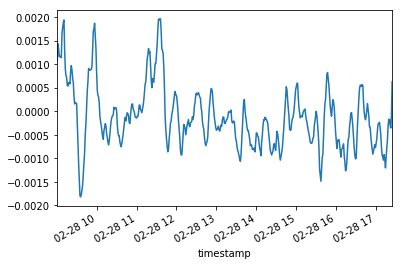

In [84]:
my_df['diff'].plot()

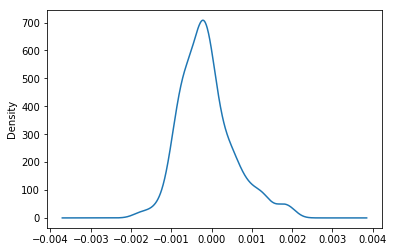

In [85]:
my_df['diff'].plot.kde()

In [86]:
my_df['diff'].mean()

-0.0001233379876338359

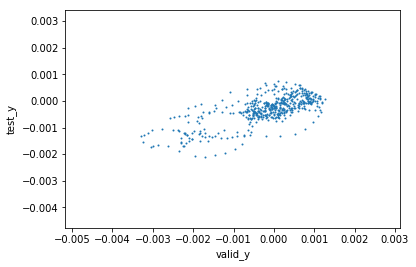

In [87]:
my_df.plot.scatter(x='valid_y', y='test_y',s=1)

In [88]:
my_df['diff'].max()

0.0019612595114189297

In [89]:
my_df.loc[my_df['valid_y'].argmax()]

last_20                    249.150000
value_ema_20_beta_98_20      0.001258
test_y                       0.000055
valid_y                      0.001258
diff                        -0.001203
Name: 2019-02-28 17:14:00+01:00, dtype: float64

In [90]:
my_df

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-28 09:01:00+01:00,252.20,-0.000660,0.000436,-0.000660,0.001096
2019-02-28 09:02:00+01:00,252.20,-0.001085,0.000346,-0.001085,0.001431
2019-02-28 09:03:00+01:00,251.75,-0.001291,0.000019,-0.001291,0.001310
2019-02-28 09:04:00+01:00,251.70,-0.001432,-0.000275,-0.001432,0.001157
2019-02-28 09:05:00+01:00,251.80,-0.001604,-0.000437,-0.001604,0.001168
2019-02-28 09:06:00+01:00,251.60,-0.001784,-0.000627,-0.001784,0.001157
2019-02-28 09:07:00+01:00,251.55,-0.001903,-0.000764,-0.001903,0.001138
2019-02-28 09:08:00+01:00,252.10,-0.002196,-0.000552,-0.002196,0.001645
2019-02-28 09:09:00+01:00,251.65,-0.002346,-0.000570,-0.002346,0.001775


In [91]:
buy_threshold = 0.0005
sell_threshold = -0.0005

action_steps = my_df[my_df['test_y']>0.0005].append(my_df[my_df['test_y']<-0.0005]).sort_values('timestamp')

In [92]:
state = 0
profit = 1
for i in range(len(my_df)):
    row = my_df.iloc[i]
    if row['test_y'] > 0.0001 and state == 0:
        print("buy at {} price:{}".format(row.index, row.last_20))
        state = 1
        price = row.last_20
    elif row['test_y'] < -0.0001 and state == 1:
        state = 0
        ratio = (row.last_20 - price) / price
        print("sell at {} price:{}".format(row.index, row.last_20)) 
        if ratio != 0:
            profit = profit * ratio
print("profit={}".format(profit))

buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:252.2
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:251.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.8
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.55
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.95
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.55
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.35
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.8
se

In [69]:
action_steps

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-26 09:02:00+01:00,255.60,-0.000461,-0.000537,-0.000461,-0.000076
2019-02-26 09:09:00+01:00,255.45,-0.000057,-0.000570,-0.000057,-0.000513
2019-02-26 09:10:00+01:00,255.35,0.000170,-0.000696,0.000170,-0.000866
2019-02-26 09:11:00+01:00,255.35,0.000364,-0.000770,0.000364,-0.001135
2019-02-26 09:12:00+01:00,255.40,0.000603,-0.000773,0.000603,-0.001377
2019-02-26 09:13:00+01:00,255.40,0.000887,-0.000745,0.000887,-0.001632
2019-02-26 09:14:00+01:00,255.40,0.001151,-0.000699,0.001151,-0.001850
2019-02-26 09:23:00+01:00,256.40,0.000542,0.000507,0.000542,-0.000035
2019-02-26 09:24:00+01:00,256.40,0.000193,0.000623,0.000193,0.000430
